<h1>Process Poll Data</h1>

Process info from Monmouth University 2020 national poll

In [1]:
import os 
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split

<h2>Rename Columns</h2>

In [86]:
nat_2020 = pd.read_csv("../data/national_march_2020/MUP213_NATL_archive.tab", sep = "\t")

In [87]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6A', 'Q6B', 'Q6C',
       'Q6D', 'Q6E', 'Q6F', 'Q7', 'Q8', 'Q9', 'Q9A.1', 'Q9A.2', 'Q9A.3',
       'Q10A', 'Q10B', 'Q10C', 'Q10D', 'Q10E', 'Q10F', 'Q10G', 'QD1', 'Q11',
       'Q12', 'Q12B', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'QD2',
       'QD2A', 'QD3', 'QD4', 'QD5', 'QD5A', 'QD6', 'QD7', 'QD8', 'QD9', 'QD10',
       'QD11', 'FINALWGT'],
      dtype='object')

In [88]:
nat_2020 = nat_2020.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12B': 'vote_choice_undecided', 
        'Q13': 'approve_trump',
        'Q14': 'approve_biden',
        'Q16': 'elec_enthusiasm',
        'Q19': 'focused_imp_issues',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender'
})

In [89]:
nat_2020 = nat_2020.drop(columns = [c for c in nat_2020.columns if 'Q' in c])

In [100]:
nat_2020['vote_choice'].value_counts()

vote_choice
2.0    358
1.0    320
8.0     39
6.0     21
9.0     12
7.0      3
Name: count, dtype: int64

In [98]:
nat_2020['vote_choice_undecided']

0      9.0
1      NaN
2      NaN
3      NaN
4      1.0
      ... 
846    NaN
847    NaN
848    3.0
849    NaN
850    NaN
Name: vote_choice_undecided, Length: 851, dtype: float64

<h2>Recode Variables</h2>

<h3>Vote Choice</h3>

In [101]:
nat_2020['vote_choice_recoded'] = nat_2020.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
nat_2020['vote_choice_recoded'] = nat_2020['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

<h3>Party Leaning</h3>

In [102]:
nat_2020['party_recoded'] = nat_2020.apply(lambda s: np.where(s['party'] in [4.0, 9.0], s['party_unaffiliated'], s['party']), axis = 1)
nat_2020['party_recoded'] = nat_2020['party_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

<h3>Age</h3>

Convert so they're all in bins

In [103]:
nat_2020['age_recoded'] = nat_2020.apply(lambda s: np.where(not pd.isnull(s['age_bin']), s['age_bin'], s['age']), axis = 1)

nat_2020['age_recoded'] = nat_2020['age_recoded'].apply(lambda s: np.where(s >= 18 and s <= 34 and not pd.isnull(s), 1.0, 
                                                        np.where(s >= 35 and s <= 54, 2.0, 3.0)))

<h3>Approval Ratings</h3>

In [104]:
nat_2020['approve_trump'] = nat_2020['approve_trump'] == 1
nat_2020['approve_biden'] = nat_2020['approve_biden'] == 1

<h3>Race</h3>

Overwrite if hispanic/latino

In [105]:
nat_2020['latino'] = nat_2020['latino'] == 1

In [106]:
def recode_race(s):
    if s['latino'] == 1 or s['race'] == 4: 
        return 4
    elif s['race'] != 5 and s['race'] != 9:
        return s['race']
    else:
        return 9

In [107]:
nat_2020['race_recoded'] = nat_2020.apply(recode_race, axis = 1)

<h3>Gender</h3>

In [108]:
nat_2020['male'] = nat_2020['gender'] == 1

In [109]:
nat_2020.to_csv("../data/nat_2020_cleaned_no_dummies.csv", index = False)

In [110]:
nat_2020['registered_vote'].value_counts()

registered_vote
1    754
2     94
9      3
Name: count, dtype: int64

In [111]:
nat_2020['age_recoded'].value_counts()

age_recoded
3.0    357
2.0    304
1.0    190
Name: count, dtype: int64

<h2>Add Dummy Variables</h2>

In [112]:
categoricals = ['top_household_concern', 'registered_vote',
                'likely_to_vote', 'vote_choice', 'vote_choice_undecided', 
                'elec_enthusiasm', 'focused_imp_issues', 'focused_imp_issues', 
                'political_leaning', 'race_recoded', 'party_recoded', 'age_recoded']

In [113]:
for category in categoricals:
    nat_2020[category] = nat_2020[category].astype('category')


dummies = pd.get_dummies(nat_2020[categoricals])

In [114]:
nat_2020 = nat_2020[[c for c in nat_2020.columns if c not in categoricals]]

In [115]:
nat_2020 = pd.concat([nat_2020, dummies], axis = 1)

In [116]:
nat_2020 = nat_2020[(nat_2020['vote_choice_recoded'] != 3.0) | 
                    (nat_2020['vote_choice_recoded'] != 7.0) |
                    (pd.isnull(nat_2020['vote_choice_recoded']) == False)]






<h2>Train Test Split</h2>

In [117]:
X_train, X_test = train_test_split(nat_2020, test_size = 0.2, random_state = 42)

In [118]:
X_train.to_csv('../data/nat_2020_train.csv', index = False)
X_test.to_csv('../data/nat_2020_test.csv', index = False)

In [119]:
X_train.columns

Index(['RESPID', 'PHTYPE', 'approve_trump', 'approve_biden', 'party',
       'party_unaffiliated', 'age', 'age_bin', 'latino', 'race', 'gender',
       'FINALWGT', 'vote_choice_recoded', 'male', 'top_household_concern_1',
       'top_household_concern_2', 'top_household_concern_3',
       'top_household_concern_4', 'top_household_concern_5',
       'top_household_concern_6', 'top_household_concern_7',
       'top_household_concern_8', 'top_household_concern_9',
       'top_household_concern_10', 'top_household_concern_11',
       'top_household_concern_12', 'top_household_concern_13',
       'top_household_concern_14', 'top_household_concern_15',
       'top_household_concern_16', 'top_household_concern_17',
       'top_household_concern_18', 'top_household_concern_19',
       'top_household_concern_20', 'top_household_concern_28',
       'top_household_concern_29', 'top_household_concern_30',
       'registered_vote_1', 'registered_vote_2', 'registered_vote_9',
       'likely_to_vote_

In [120]:
nat_2020['vote_choice_recoded']
# 1 is trump, 2 is biden, 3 is other/undecided/none
nat_2020['vote_choice_recoded'].value_counts()

vote_choice_recoded
2.0    381
1.0    334
3.0     38
Name: count, dtype: int64

## drop columns that made voter choice recoded column

In [144]:
nat_2020_clean = nat_2020.drop(columns=['vote_choice_1.0',
       'vote_choice_2.0', 'vote_choice_6.0', 'vote_choice_7.0',
       'vote_choice_8.0', 'vote_choice_9.0', 'vote_choice_undecided_1.0',
       'vote_choice_undecided_2.0', 'vote_choice_undecided_3.0',
       'vote_choice_undecided_9.0', 'focused_imp_issues_1', 'focused_imp_issues_2', 'focused_imp_issues_9', 'RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race'])

# keep or or drop FINALWGT?
# use state? income? education? -> not in data rn, keep in mind for future


# nat_2020_clean.to_csv('yeet.csv', index = False)

In [145]:
# pull up column focused_imp_issues_2

nat_2020_clean.columns

Index(['approve_trump', 'approve_biden', 'FINALWGT', 'vote_choice_recoded',
       'male', 'top_household_concern_1', 'top_household_concern_2',
       'top_household_concern_3', 'top_household_concern_4',
       'top_household_concern_5', 'top_household_concern_6',
       'top_household_concern_7', 'top_household_concern_8',
       'top_household_concern_9', 'top_household_concern_10',
       'top_household_concern_11', 'top_household_concern_12',
       'top_household_concern_13', 'top_household_concern_14',
       'top_household_concern_15', 'top_household_concern_16',
       'top_household_concern_17', 'top_household_concern_18',
       'top_household_concern_19', 'top_household_concern_20',
       'top_household_concern_28', 'top_household_concern_29',
       'top_household_concern_30', 'registered_vote_1', 'registered_vote_2',
       'registered_vote_9', 'likely_to_vote_1.0', 'likely_to_vote_2.0',
       'likely_to_vote_3.0', 'likely_to_vote_4.0', 'likely_to_vote_5.0',
       'el

In [146]:
# get propensity scores, use those as a column in the data, then train on data + that then 


In [147]:
nat_2020_clean['vote_choice_recoded'].value_counts()
# if vote choice recorded is 7, make the value 3
nat_2020_clean['vote_choice_recoded'] = nat_2020_clean['vote_choice_recoded'].apply(lambda s: np.where(s == 7, 3, s))
nat_2020_clean['vote_choice_recoded'].isna().sum()

98

In [148]:
nat_2020_clean['vote_choice_recoded'].value_counts().sum()

753

In [149]:
# drop if vote choice recorded is null
nat_2020_clean = nat_2020_clean.dropna(subset = ['vote_choice_recoded'])
# vote choice recoded to int
nat_2020_clean['vote_choice_recoded'] = nat_2020_clean['vote_choice_recoded'].astype(int)

In [177]:
X = nat_2020_clean.drop(columns = ['vote_choice_recoded'])
y = nat_2020_clean['vote_choice_recoded']
# train test split
# TODO: consider stratifying by anything???? 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)

In [178]:
y_test.value_counts()

vote_choice_recoded
2    82
1    64
3     5
Name: count, dtype: int64

In [179]:
y_train.value_counts()

vote_choice_recoded
2    299
1    270
3     33
Name: count, dtype: int64

In [180]:
import os
import numpy as np
import pandas as pd

from utils import * 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, auc, roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np 
import os 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor, XGBClassifier

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

In [181]:
models = [
  

    ("Logistic Regression Classification", LogisticRegression(), {'C': [1, 2]}),
    ("SVC", SVC(C = 10), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    ("Decision Tree Regression", DecisionTreeClassifier(), {'max_depth':[0,2, 5]}),
    ("Random Forest Classification", RandomForestClassifier(), {'n_estimators': [100,150,200]}),
    ("Random Forest Classification2", RandomForestClassifier(min_samples_split = 3,  n_estimators=75), {'n_estimators': [100,150,200]}), 
    ("Gradient Boosting Classification", GradientBoostingClassifier(criterion='squared_error', n_estimators=440, max_depth=5, learning_rate=0.012, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification2", GradientBoostingClassifier(criterion='squared_error', n_estimators=100, max_depth=7, learning_rate=0.2, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification3", GradientBoostingClassifier( n_estimators=375, max_depth=3, learning_rate=0.02, random_state=0, max_features=2), {'n_estimators': [100,150,200]}),
    # ('xgb', XGBClassifier(), {'n_estimators': [100,150,200]}),

    ("K-Nearest Neighbors Classification", KNeighborsClassifier(), {'n_neighbors': [3,5]}),
    # ("Neural Network Classification", MLPClassifier(max_iter=1000)),  # Specify appropriate hyperparameters

    
]

In [182]:
for model in models:
  
    name = model[0]
    print(model[0])
    clf = model[1]
    # print(model[2])
    pipe = Pipeline([('scaler', StandardScaler()), (name, clf)])
    #model.fit(trainX_prepared, trainY)
    grids =  GridSearchCV(pipe, param_grid={}, scoring='f1_weighted' ,cv=3)
    grids.fit(X_train, y_train)
    if name == 'Gradient Boosting Classification':
        new_model = clf
    #print('train result', result['test_score'])
    grids.best_score_
    # print('mean_score:', -np.mean(result['test_score']))
    y_preds = grids.best_estimator_.predict(X_test)

    print(f1_score(y_test, y_preds, average='weighted'))
    
   

Logistic Regression Classification
0.8305810816206627
SVC
0.7988461305617499
Decision Tree Regression
0.7899037860802199
Random Forest Classification
0.8396487908513004
Random Forest Classification2
0.8327550003063401
Gradient Boosting Classification
0.855774900467862
Gradient Boosting Classification2
0.8260429016939805
Gradient Boosting Classification3
0.8555585536715146
K-Nearest Neighbors Classification
0.7802466295410865
Neural Network Classification
0.8187703309273259


In [186]:
logreg = LogisticRegression().fit(X_train, y_train)
y_preds_logreg = logreg.predict(X_test)
print(f1_score(y_test, y_preds_logreg, average='weighted'))
print(classification_report(y_test, y_preds_logreg))
# precision: how many did you guess right out of all the ones you guessed right for that class
# recall: how many did you guess right out of all the ones that were actually that class

0.8434279021146304
              precision    recall  f1-score   support

           1       0.90      0.84      0.87        64
           2       0.85      0.88      0.86        82
           3       0.17      0.20      0.18         5

    accuracy                           0.84       151
   macro avg       0.64      0.64      0.64       151
weighted avg       0.85      0.84      0.84       151



0.8229456904174473
              precision    recall  f1-score   support

           1       0.85      0.83      0.84        64
           2       0.83      0.89      0.86        82
           3       0.00      0.00      0.00         5

    accuracy                           0.83       151
   macro avg       0.56      0.57      0.57       151
weighted avg       0.81      0.83      0.82       151



<Axes: >

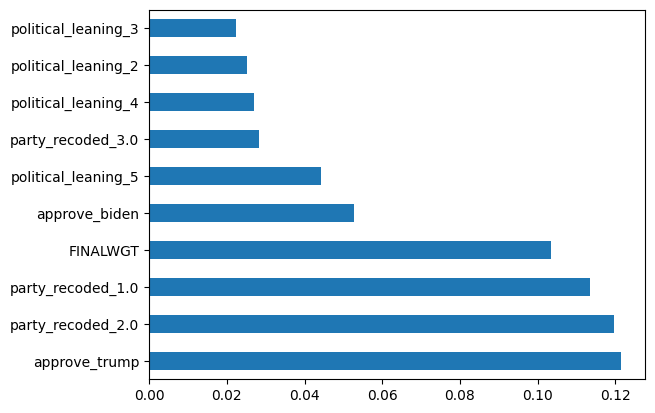

In [191]:
rf = RandomForestClassifier().fit(X_train, y_train)
y_preds_rf = rf.predict(X_test)
print(f1_score(y_test, y_preds_rf, average='weighted'))
print(classification_report(y_test, y_preds_rf))
features=X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

# plt.figure(1)
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance')
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [187]:
new_model.fit(X_train, y_train)
y_preds = new_model.predict(X_test)
print(f1_score(y_test, y_preds, average='weighted'))
print(classification_report(y_test, y_preds))

0.855774900467862
              precision    recall  f1-score   support

           1       0.89      0.88      0.88        64
           2       0.86      0.91      0.89        82
           3       0.00      0.00      0.00         5

    accuracy                           0.87       151
   macro avg       0.58      0.60      0.59       151
weighted avg       0.84      0.87      0.86       151



In [184]:
y_test.to_numpy()

array([1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2,
       2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2,
       2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 3, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2,
       1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 3, 1, 2, 3,
       1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 3, 1, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2])

In [185]:
y_preds

array([1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1,
       2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2,
       2, 1, 2, 3, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2,
       1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2])